In [67]:
#list of Import

import os
import random
import requests
import time
import ast
import numpy as np
from glob import glob
import cv2                
from PIL import Image, ImageFile 
import time
from collections import OrderedDict 

import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.models as models


import matplotlib.pyplot as plt                        
%matplotlib inline

ImageFile.LOAD_TRUNCATED_IMAGES = True

# check if CUDA is available
use_cuda = torch.cuda.is_available()

#pip install torchsummary
from torchsummary import summary

import Helper

In [8]:
# load filenames for human and dog images
dataset = np.array(glob("data/*/*/*"))
trainset = np.array(glob("data/train/*/*"))
validset = np.array(glob("data/valid/*/*"))
testset = np.array(glob("data/test/*/*"))
# print number of images in each dataset
print('There are %d total images.' % len(dataset))
print('There are %d total train images.' % len(trainset))
print('There are %d total validation images.' % len(validset))
print('There are %d total test images.' % len(testset))

There are 2750 total images.
There are 2000 total train images.
There are 150 total validation images.
There are 600 total test images.


# Data loader

We prepare three types of transform based on the type of data we get. We want the training data to be augmented whereas we don't want for the Valid and Test datatsets

In [9]:
data_dir = 'data/'

train_transforms = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([                                 
    transforms.Resize(256),
    transforms.CenterCrop(224),                                                              
    transforms.ToTensor(),                                    
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

image_datasets = {x: datasets.ImageFolder(data_dir + x, transform = train_transforms if x == 'train' else valid_transforms if x == 'valid' else test_transforms) for x in ['train', 'valid', 'test']}

loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}


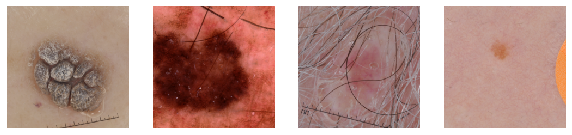

In [10]:
data_iter = iter(loaders_scratch['valid'])

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    Helper.imshow(images[ii], ax=ax)

In [17]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler) 

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min and epoch > (n_epochs - 5):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [18]:
model_transfer = models.vgg16(pretrained=True)

print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 3 type)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 3)

model_transfer.classifier[6] = last_layer

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier[6].out_features)

if use_cuda:
    model_transfer = model_transfer.cuda()

4096
1000
3


In [19]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [21]:
# train the model
n_epochs = 1

loaders_transfer = loaders_scratch

model_transfer =  train(n_epochs, 
                        loaders_transfer, 
                        model_transfer, 
                        optimizer_transfer, 
                        criterion_transfer, 
                        use_cuda, 
                        'model_transfer.pt')

Epoch: 1 	Training Loss: 0.871227 	Validation Loss: 1.019542
Validation loss decreased (inf --> 1.019542).  Saving model ...


In [65]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


<All keys matched successfully>

In [74]:
summary(model_transfer,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [25]:
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.880811


Test Accuracy: 65% (393/600)


In [66]:
class_names = git p for item in image_datasets['train'].classes]

def mole_id(img_path):
    # load the image and return the predicted breed
    #image_tensor = image_to_tensor(img_path)
    
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(size=224),
                                          transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image_tensor = image_tensor.cuda()

    # get sample result
    result = model_transfer(image_tensor)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(result, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
    
    return class_names[pred]

nevus


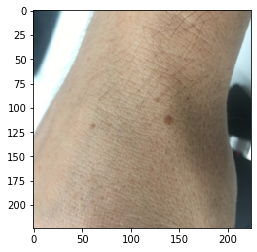

In [64]:
img_path = "test/test.jpg"

print(mole_id(img_path))
#image = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
transformations = transforms.Compose([transforms.Resize(size=224), transforms.CenterCrop((224,224))])
image = transformations(img)
plt.imshow(image)
plt.show()